In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit
from collections import Counter
import pdb

# The IMF

The goal here is to gain familiarity with Popstar and making an IMF. Here we make a cluster of 10^4 solar masses using the Kroupa 2001 IMF.

21417


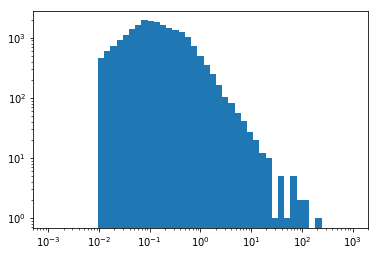

In [2]:
#Kroupa_2001 IMF. cluster mass of 10**4 M_sol
mass_array_10e4_Kroupa_2001 = np.loadtxt("masses.txt", delimiter = " " )

#how many stars are in the cluster?
print(len(mass_array_10e4_Kroupa_2001))

xvals1 = np.arange(0.01,0.08,0.001)
yvals1 = xvals1**0.7
xvals2 = np.arange(0.08,0.5, 0.01)
yvals2 = xvals2**-0.3
xvals3 = np.arange(0.5,100,1)
yvals3 = xvals3**-1.3

plt.hist(mass_array_10e4_Kroupa_2001, bins = np.logspace(-3,3,50))
plt.xscale('log')
plt.yscale('log')
plt.show()

# The IFMF

### Black Hole IFMF

We attempt to reproduce the top half of Figure 1 and Figure 4 of Raithel et al. using equations (1) through (4), which gives fits for the IFMF for black holes. Note we've done a little bit of renaming here.There are two branches, Branches I and II, which are respectively

\begin{align*}
    M_{BH, I}(M_{ZAMS}; f_{ej}) &= f_{ej}M_{BH, core}(M_{ZAMS}) + (1-f_{ej})M_{BH, all}(M_{ZAMS}), \, 15 \leq M_{ZAMS} < 40M_\odot \\
    M_{BH, II}(M_{ZAMS}) &= 5.796 + 1.05 \times 10^9 (M_{ZAMS})^{-4.94}, \, 45 \leq M_{ZAMS} \leq 120M_\odot \\
\end{align*}

where $f_{ej}$ is the ejection fraction, and

\begin{align*}
    M_{BH, core}(M_{ZAMS}) &= -1.98 + 0.411M_{ZAMS} \\
    M_{BH, all}(M_{ZAMS}) &= 16.1 - 0.194(M_{ZAMS} - 23.9) - 0.041(M_{ZAMS} - 23.9)^2 + 0.00307(M_{ZAMS} - 23.9)^3.
\end{align*}

We pick $f_{ej} = 0.9$, as the paper suggests this is the best value. We also fill in the gap between 40 and 45 solar masses by just extending the domain of Branches I and II. Thus, the IFMF for black holes is 

\begin{align}
    IMFM_{BH}(M_{ZAMS}) &= 0.9 (-1.98 + 0.411M_{ZAMS}) + 0.1 [16.1 - 0.194(M_{ZAMS} - 23.9) - 0.041(M_{ZAMS} - 23.9)^2 + 0.00307(M_{ZAMS} - 23.9)^3], \, 15 < M_{ZAMS} < 42.22 \\
    &= 5.796 + 1.05 \times 10^9 M_{ZAMS}^{-4.94}, \, 42.22 < M_{ZAMS} < 120 
\end{align}

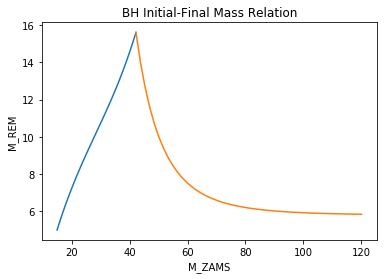

In [3]:
#Equation (1)
def BHMassCore(MZAMS):
    return -1.98 + 0.411*MZAMS

#Equation (2)
def BHMassAll(MZAMS):
    return 16.1 - 0.194 * (MZAMS - 23.9) - 0.041 * (MZAMS - 23.9)**2 + 0.00307 * (MZAMS - 23.9)**3

#Equation (3)
def BHMassCoreHigh(MZAMS):
    return 5.796 + 1.05 * 10**9 * MZAMS**-4.94

#Equation (4)
def BHMassExtrapolate(MZAMS, f_ej):
    return f_ej * BHMassCore(MZAMS) + (1 - f_ej) * BHMassAll(MZAMS)

#Branch I, this is defined different from the paper
BHmassRange1 = np.linspace(15,42.22)

#Branch II, this is defined different from the paper
BHmassRange2 = np.linspace(42.22,120)

#Plots f_ej = 0.9
plt.title("BH Initial-Final Mass Relation")
plt.xlabel("M_ZAMS")
plt.ylabel("M_REM")
plt.plot(BHmassRange1,BHMassExtrapolate(BHmassRange1,0.9))
plt.plot(BHmassRange2,BHMassCoreHigh(BHmassRange2))
plt.show()

Note that all the black holes produced are between 5 to 16 solar masses.

### Neutron Star IFMF

Raithel et al. gives seven different branches for neutron star formation, with quite complex fits for each of them, in equations (10) to (15). However, all the neutron stars produced are around 1.6 $\pm$ 0.5 solar masses. For our purposes, we can approximate the final mass function to be flat. So, we'll approximate the neutron star IFMF as

\begin{equation}
    IFMF_{NS}(M_{ZAMS}) = 1.6, 9 < M_{ZAMS} < 120.
\end{equation}

### White Dwarf IFMF

A quick perusal of the literature seems to show general consensus on a linear IFMF (which they call the Initial-Final Mass Relation, or IFMR). The exact fits vary, but we can just take one and run with it. From http://online.kitp.ucsb.edu/online/snovae-c07/williams/pdf/Williams_SnovaeConf_KITP.pdf we have

\begin{equation*}
    IFMF_{WD}(M_{ZAMS}) = 0.358 + 0.123M_{ZAMS}
\end{equation*}

FIXME: What ranges is this equation valid for? Certainly not less than 0.358 solar masses- you'll get something from nothing!

### Getting the remnant mass

$\texttt{getRemMass}$ is a simulation that will, given some distribution of ZAMS masses, spit out the remnant masses and the remnant types. 

In [4]:
#Given the ZAMS mass, gives the remnant mass and type of compact object
#Slightly different version of getRemnantMass
#Assumptions: all neutron stars are the same mass
#Assumptions: WD progenitor masses go from 1 to 9 solar masses
def getRemMass(MZAMS,f_ej):
    """
    type BH = Black Hole
    type NS = Neutron Star
    type WD = White Dwarf
    type small = out of lower range
    type big = out of upper range
    """
    n = random.randint(1,101)
    if (MZAMS >= 0.5) and (MZAMS < 9):
        typecode = 'WD'
        return 0.358 + 0.123 * MZAMS,typecode
    elif (MZAMS >= 9) and (MZAMS <= 15):
        typeCode = 'NS'
        return 1.6,typeCode
    elif (MZAMS > 15) and (MZAMS <= 17.8):
        if n > 68:
            typeCode = 'BH'
            return BHMassExtrapolate(MZAMS,f_ej),typeCode
        else:
            typeCode = 'NS'
            return 1.6,typeCode
    elif (MZAMS > 17.8) and (MZAMS <= 18.5):
        if n > 83:
            typeCode = 'BH'
            return BHMassExtrapolate(MZAMS,f_ej),typeCode
        else:
            typeCode = 'NS'
            return 1.6,typeCode
    elif (MZAMS > 18.5) and (MZAMS <= 21.7):
        if n > 50:
            typeCode = 'BH'
            return BHMassExtrapolate(MZAMS,f_ej),typeCode
        else:
            typeCode = 'NS'
            return 1.6,typeCode
    elif (MZAMS > 21.7) and (MZAMS <= 25.2):
        typeCode = 'BH'
        return BHMassExtrapolate(MZAMS,f_ej),typeCode
    elif (MZAMS > 25.2) and (MZAMS <= 27.5):
        if n > 65:
            typeCode = 'BH'
            return BHMassExtrapolate(MZAMS,f_ej),typeCode
        else:
            typeCode = 'NS'
            return 1.6,typeCode
    elif (MZAMS > 27.5) and (MZAMS <= 60):
        typeCode = 'BH'
        if MZAMS > 42:
            return BHMassCoreHigh(MZAMS),typeCode
        else:
            return BHMassExtrapolate(MZAMS,f_ej),typeCode
    elif (MZAMS > 60) and (MZAMS <= 120):
        if n > 40:
            typeCode = 'BH'
            return BHMassCoreHigh(MZAMS),typeCode
        else:
            typeCode = 'NS'
            return 1.6,typeCode
    elif MZAMS < 0.5:
        typeCode = 'small'
        return 0, typeCode
    else:
        typeCode = 'big'
        return 0, typeCode 

This is a quick demo of $\texttt{getRemMass}$, assuming a flat input distribution of ZAMS masses.

Counter({'BH': 601, 'NS': 323, 'WD': 69, 'small': 7})


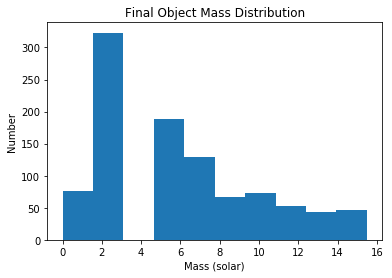

In [5]:
typeArrayFlat = massArrayFlat = []

#number of progenitor stars
N = 1000

for i in range(N):
    randomZAMS = random.randint(0,120)
    remnantMassFlat, typeCodeFlat = getRemMass(randomZAMS,0.9)
    typeArrayFlat = np.append(typeArrayFlat, typeCodeFlat)
    massArrayFlat = np.append(massArrayFlat, remnantMassFlat)

#count how many WD, NS, and BH there are    
print(Counter(typeArrayFlat))

#plot the mass distribution
plt.hist(massArrayFlat)
plt.xlabel("Mass (solar)")
plt.ylabel("Number")
plt.title("Final Object Mass Distribution")
plt.show()

To get a realistic distribution, you would draw from the IMF to get the relative weightings correct. Here we use the Kroupa 2001 IMF for a cluster of $10^4 M_\odot$.

Counter({'small': 18069, 'WD': 3269, 'NS': 54, 'BH': 22, 'big': 3})


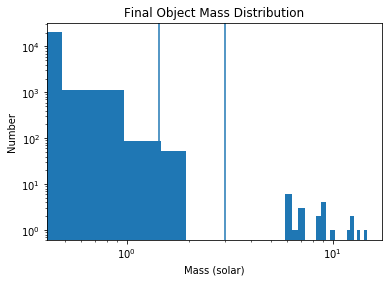

In [6]:
typeArrayKroupa = massArrayKroupa = []

#number of progenitor stars
N = len(mass_array_10e4_Kroupa_2001)

for i in range(N):
    remnantMassKroupa, typeCodeKroupa = getRemMass(mass_array_10e4_Kroupa_2001[i],0.9)
    massArrayKroupa = np.append(massArrayKroupa, remnantMassKroupa)
    typeArrayKroupa = np.append(typeArrayKroupa, typeCodeKroupa)
    
#counts the different types    
print(Counter(typeArrayKroupa))    

BHarrayKroupa = [i for i in massArrayKroupa if i > 3]    
NSarrayKroupa = [i for i in massArrayKroupa if i <= 3 and i > 1.44]
WDarrayKroupa = [i for i in massArrayKroupa if i > 0 and i <= 1.44]
NAarrayKroupa = [i for i in massArrayKroupa if i == 0]

#plot the mass distribution
plt.hist(massArrayKroupa, bins = 10*3)
plt.axvline(x=3)
plt.axvline(x=1.44)
plt.xlabel("Mass (solar)")
plt.ylabel("Number")
plt.title("Final Object Mass Distribution")
plt.xscale('log')
plt.yscale('log')
plt.show()

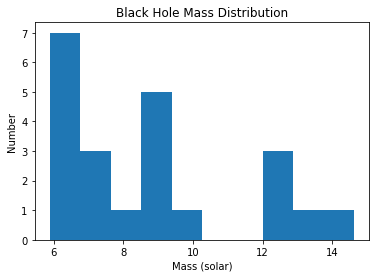

In [7]:
plt.hist(BHarrayKroupa)
plt.xlabel("Mass (solar)")
plt.ylabel("Number")
plt.title("Black Hole Mass Distribution")
plt.show()

Since we're mostly interested in the distribution of black holes, let's just consider the high mass end of the IMF. In particular, here we consider a cluster of $10^6 M_\odot$, of the Kroupa IMF, just from 9 to 120 $M_\odot$.

1000004.11178


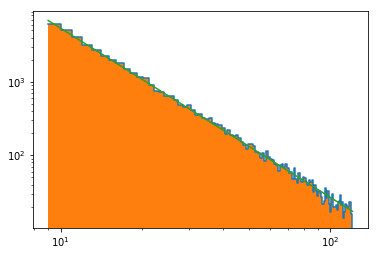

In [8]:
#High_Mass_Casey IMF. cluster mass of 10**6 M_sol
mass_array_10e6_High_Mass = np.loadtxt("highmasses.txt", delimiter = " " )

#Verify the mass of the cluster
clustermass = np.sum(mass_array_10e6_High_Mass)
print(clustermass)

#make bins all width 1
x1 = np.linspace(9,121,111)
hist1,bins1 = np.histogram(mass_array_10e6_High_Mass, bins = np.linspace(9,121,111))
plt.plot(bins1[:-1],hist1,drawstyle='steps-post')
plt.hist(mass_array_10e6_High_Mass, bins = np.linspace(9,121,111))
#Attempted fit...
plt.plot(x1,1.07*10**6*x1**-2.3)
plt.xscale('log')
plt.yscale('log')
plt.show()

Note: I spent an embarrassingly large amount of time trying to understand why I couldn't plot the analytic curve correctly onto the histogram (the normalization was wrong.) It's actually pretty obvious if you think about it (changing bin widths will change the curve that fits the histogram.) This might become a short writeup for me to explain it to myself.

FIXME: ADDITIONAL THOUGHT... should I have used the $\alpha$ version instead of the $\Gamma$ version?

Counter({'NS': 30636, 'BH': 15282})


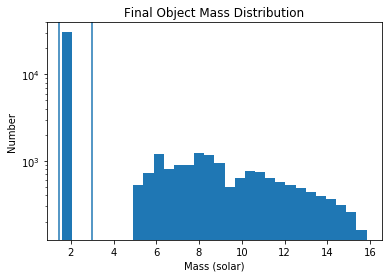

In [9]:
typeArrayHigh = massArrayHigh = []

#number of progenitor stars
N = len(mass_array_10e6_High_Mass)

for i in range(N):
    remnantMassHigh, typeCodeHigh = getRemMass(mass_array_10e6_High_Mass[i],0.9)
    massArrayHigh = np.append(massArrayHigh, remnantMassHigh)
    typeArrayHigh = np.append(typeArrayHigh, typeCodeHigh)
    
#counts the different types    
print(Counter(typeArrayHigh))    

BHarrayHigh = [i for i in massArrayHigh if i > 3]    
NSarrayHigh = [i for i in massArrayHigh if i <= 3 and i > 1.44]
WDarrayHigh = [i for i in massArrayHigh if i > 0 and i <= 1.44]
NAarrayHigh = [i for i in massArrayHigh if i == 0]

#plot the mass distribution
plt.hist(massArrayHigh, bins = 10*3)
plt.axvline(x=3)
plt.axvline(x=1.44)
plt.xlabel("Mass (solar)")
plt.ylabel("Number")
plt.title("Final Object Mass Distribution")
#plt.xscale('log')
plt.yscale('log')
plt.show()

Fun fact: if you comment out the plt.xscale('log') line, you can see the mass gap between neutron stars and black holes :D 

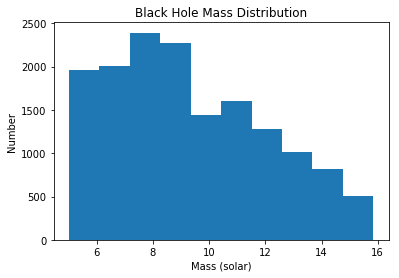

In [10]:
plt.hist(BHarrayHigh)
plt.xlabel("Mass (solar)")
plt.ylabel("Number")
plt.title("Black Hole Mass Distribution")
plt.show()

# Number of BHs in the Milky Way

A guesstimate: our galaxy cluster was $10^4 M_\odot$, with 21417 stars (let's just say $2 \times 10^4$ stars). According to the internet, the Milky Way has about 200 billion ($2 \times 10^{11}$) stars. From $2 \times 10^4$ stars, we get about 20 black holes. Extrapolating that number, we expect the Milky Way to have about $2 \times 10^8$ black holes, or 200 million black holes. The internet claims in the Milky Way has about 100 million black holes.

# Analytic Formula for the Black Hole Mass Distribution

$\texttt{getRemDist}$ uses the analytic formulas for the IMF and the IFMF to figure out the remnant masses and distribution.

In [11]:
#Assumptions: all neutron stars are the same mass
#Assumptions: WD progenitor masses go from 1 to 9 solar masses

#This is the number of stars, in THOUSANDS! (i.e. to get the real number, multiply by 10^3)
def number(MZAMS):
    return 1.0735*10**3*MZAMS**-1.3

def getRemDist(MZAMS, f_ej):
    finalMassArray = []
    for i in np.arange(len(MZAMS)):
        num = number(MZAMS[i])
        if (MZAMS[i] >= 9) and (MZAMS[i] <= 15):
            num = int(num)
            finalMassArray = np.append(finalMassArray, 1.6*np.ones(num))
        elif (MZAMS[i] > 15) and (MZAMS[i] <= 17.8):
            BHnum = int(num*0.32)
            NSnum = int(num*0.68)
            BHmass = BHMassExtrapolate(MZAMS[i],0.9)
            finalMassArray = np.append(finalMassArray, BHmass*np.ones(BHnum))
            finalMassArray = np.append(finalMassArray, 1.6*np.ones(NSnum))
        elif (MZAMS[i] > 17.8) and (MZAMS[i] <= 18.5):
            BHnum = int(num*0.17)
            NSnum = int(num*0.83)
            BHmass = BHMassExtrapolate(MZAMS[i],0.9)
            finalMassArray = np.append(finalMassArray, BHmass*np.ones(BHnum))
            finalMassArray = np.append(finalMassArray, 1.6*np.ones(NSnum))
        elif (MZAMS[i] > 18.5) and (MZAMS[i] <= 21.7):
            BHnum = NSnum = int(num*0.5)
            BHmass = BHMassExtrapolate(MZAMS[i],0.9)
            finalMassArray = np.append(finalMassArray, BHmass*np.ones(BHnum))
            finalMassArray = np.append(finalMassArray, 1.6*np.ones(NSnum))
        elif (MZAMS[i] > 21.7) and (MZAMS[i] <= 25.2):
            num = int(num)
            BHmass = BHMassExtrapolate(MZAMS[i],0.9)
            finalMassArray = np.append(finalMassArray, BHmass*np.ones(BHnum))
        elif (MZAMS[i] > 25.2) and (MZAMS[i] <= 27.5):
            BHnum = int(num*0.35)
            NSnum = int(num*0.65)
            BHmass = BHMassExtrapolate(MZAMS[i],0.9)
            finalMassArray = np.append(finalMassArray, BHmass*np.ones(BHnum))
            finalMassArray = np.append(finalMassArray, 1.6*np.ones(NSnum))
        elif (MZAMS[i] > 27.5) and (MZAMS[i] <= 42.2):
            num = int(num)
            BHmass = BHMassExtrapolate(MZAMS[i],0.9)
            finalMassArray = np.append(finalMassArray, BHmass*np.ones(num))
        elif (MZAMS[i] > 42.4) and (MZAMS[i] <= 60):
            num = int(num)
            BHmass = BHMassCoreHigh(MZAMS[i])
            finalMassArray = np.append(finalMassArray, BHmass*np.ones(num))
        elif (MZAMS[i] > 60) and (MZAMS[i] <= 120):
            BHnum = int(num*0.6)
            NSnum = int(num*0.4)
            BHmass = BHMassCoreHigh(MZAMS[i])
            finalMassArray = np.append(finalMassArray, BHmass*np.ones(BHnum))
            finalMassArray = np.append(finalMassArray, 1.6*np.ones(NSnum))
        else:
            finalMassArray = finalMassArray
    return finalMassArray

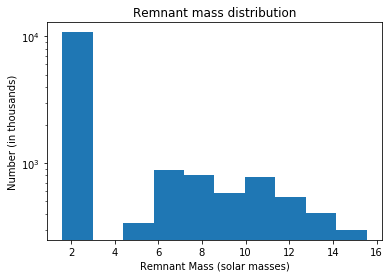

In [12]:
logMassVector = np.logspace(0.9,2.1,1000)
logMasses = getRemDist(logMassVector,0.9)
plt.hist(logMasses)
plt.yscale("log")
plt.title("Remnant mass distribution")
plt.xlabel("Remnant Mass (solar masses)")
plt.ylabel("Number (in thousands)")
plt.show()